## Level of sharing/concordance of caQTLS between the cell types in our study

- **Rev2.7**   *I was unsure of the level of concordance of cAQTL effects between the different major celltypes. Figure 2A illustrates overlap or not between major cell types. But this could be related to power, rather than true biological differences. Have the authors done an interaction analysis to identify caQTLs with evidence of cell type specific effects?*
 
The reviewer may refer to something similar as in the paper of Alasoo et al 2016 (Gaffney): In each condition, we first identified all genes and corresponding lead variants that displayed significant association at the 10% FDR level from RASQUAL. For each gene, we kept only independent lead variants (R2 <0.8). Finally, we used all independent pairs of genes and corresponding lead variants to test whether the eQTL effect size was significantly different among conditions. This procedure was equivalent to testing the significance of the interaction term between the condition and lead eQTL variant for each gene. 
Specifically ANOVA was used to compare two models for each gene-lead SNP pair:
- H0: expression~genotype+condition+covariates
- H1: expression~genotype+condition+genotype:condition+covariates
- P-values of rejecting H0 were calculated and BH correction performed to identify condition-specific QTLs


In [1]:
library(repr)
library(pheatmap)
suppressPackageStartupMessages(library(DESeq2))

In [2]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2/anova_interaction/')

In [3]:
ids = c(2:5, 8:10,12:14)

### Prepare data
Calculate LD in EUR  for all caQTL vars using plink (see command in the anova_interaction folder); make a matrix with peax x sample in each cell type combined together and normalize it using vst (alternatively try cqn package)

In [4]:
celltypes = c('b', "t",'mono',  'nk')

In [5]:
longf     = read.table('../summarized_caqtls/run3/EUR_caqtl_leads_run3.tsv', header=T)
genotypes = read.table("All_tested_genotypes.tsv", header=T)

In [6]:
longfsub = subset(longf, cell %in% celltypes & flag_fdr10==TRUE & exclude==FALSE)
writeLines(gsub("chr","",as.character(unique(longfsub$varID))), "lead_caQTL_vars.txt")

In [7]:
for (ce in celltypes){
    mat = read.table(paste0("../rasqual_eur/broad/",ce, "/",ce, ".count_matrix"), header=TRUE, row.names=1)
    mat = mat[,6:ncol(mat)]
    colnames(mat) = paste0("PBMC",  ids, ".", ce)
    if(ce == celltypes[1]){
        counts = mat
    }else{
        if(sum(rownames(counts)!= rownames(mat))==0){
        counts = cbind(counts, mat)}
    }
}

In [9]:
write.csv(counts, "all_broad_raw_counts.csv")

In [8]:
counts = read.csv("all_broad_raw_counts.csv", row.names=1)

In [10]:
vst_counts = vst(as.matrix(counts), blind=FALSE)

In [11]:
cov = read.table("sample_covariates.txt", header=T, check.names = F)

In [13]:
info = data.frame(celltype = rep(celltypes, each =10), sample_numb = rep( ids,4), 
                  samp_cell = paste(rep (rownames(cov),4), rep(celltypes, each =10) , sep="."),
                  sample_name = rep (rownames(cov),4), age = rep(cov$Age, 4), sex = rep(cov$Sex,4),
                  rbind(cov[,3:6],cov[,3:6],cov[,3:6],cov[,3:6])  )

In [14]:
pca <- prcomp(t(vst_counts))
percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

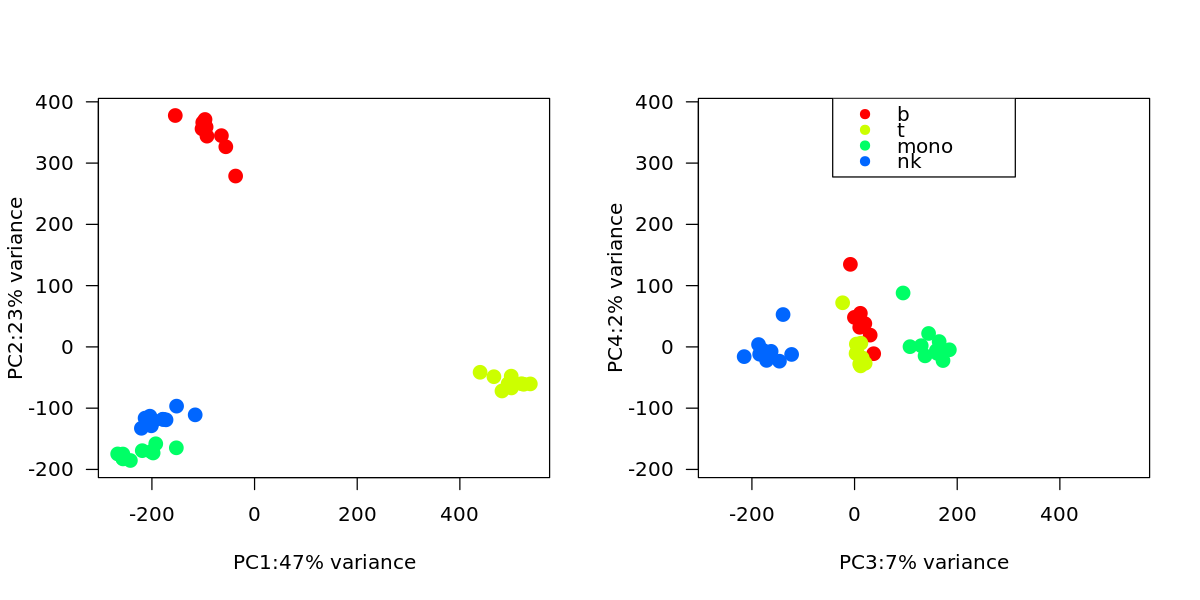

In [16]:
d <- data.frame(PC1=pca$x[,1], PC2=pca$x[,2] , PC3=pca$x[,3], PC4=pca$x[,4], info, 
                Color = rainbow(5)[as.numeric(as.factor(info$celltype))])
options(repr.plot.width=10, repr.plot.height=5)
par (mfrow=c(1,2))
plot(data=d, PC2~PC1,  xlab=(paste0("PC1:" ,round(percentVar[1] * 100),"% variance")),
       ylab=(paste0("PC2:",round(percentVar[2] * 100),"% variance")) , 
       pch= 19, 
      col = as.character(d$Color),  cex=1.5, las=1, xlim=c(min(d$PC1)-5, max(d$PC1)+5) , 
         ylim=c(min(d$PC2)-5, max(d$PC2)+5) )
plot(data=d, PC4~PC3,  xlab=(paste0("PC3:" ,round(percentVar[3] * 100),"% variance")),
       ylab=(paste0("PC4:",round(percentVar[4] * 100),"% variance")) , 
       pch= 19, 
      col = as.character(d$Color),  cex=1.5, las=1, xlim=c(min(d$PC1)-5, max(d$PC1)+5) , 
         ylim=c(min(d$PC2)-5, max(d$PC2)+5) )

legend("top", pch=19, col = rainbow(5), legend = unique(info$celltype))

In [17]:
info = data.frame ( info, PC1=pca$x[,1], PC2=pca$x[,2] , PC3=pca$x[,3], PC4=pca$x[,4])

In [18]:
caQTL_counts = subset(vst_counts, rownames(vst_counts) %in% longfsub$Feature)

In [19]:
dim(caQTL_counts)

[1] 5908   40

In [20]:
longfsub = longfsub[order(longfsub$P_VAl),]

In [21]:
longfs2 = subset(longfsub, !duplicated(longfsub[,c('varID', "Feature")]))

In [22]:
ag = aggregate(varID~Feature,longfs2,length )

In [23]:
table(ag[,2])


   1    2    3    4 
5398  440   63    7 

### Perform Test

In [26]:
peaksnps_tests = longfs2

In [27]:
dim(peaksnps_tests)

[1] 6495   32

In [28]:
covariate_names = c("age", "sex", "GT1","GT2","GT3","GT4", "PC1","PC2","PC3","PC4")

qtl_formula = as.formula(paste("expression ~ genotype + celltype ", 
                               paste(covariate_names, collapse = " + "), sep = "+ "))
interaction_formula = as.formula(paste("expression ~ genotype + celltype + celltype:genotype ", 
                                       paste(covariate_names, collapse = " + "), sep = "+ "))

In [29]:
qtl_formula

expression ~ genotype + celltype + age + sex + GT1 + GT2 + GT3 + 
    GT4 + PC1 + PC2 + PC3 + PC4

In [30]:
result_complete = list()
results_pvals = vector(mode = "numeric",length = nrow(peaksnps_tests))
  for(i in 1:nrow(peaksnps_tests)){
i=1
    gene_id = as.character(peaksnps_tests[i,]$Feature)
    snp_id  = as.character(peaksnps_tests[i,]$varID)


sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),length(celltypes)))      
      
no_interaction = lm(qtl_formula, as.data.frame(sample_data))
interaction    = lm(interaction_formula, as.data.frame(sample_data))
res            = anova(no_interaction, interaction)
      results_pvals [i] = res[2,6]
      
      test = list(anova = res, qtl_model = no_interaction, interaction_model = interaction)
      result_complete[[paste(gene_id,snp_id, sep = ";")]] = test
  }

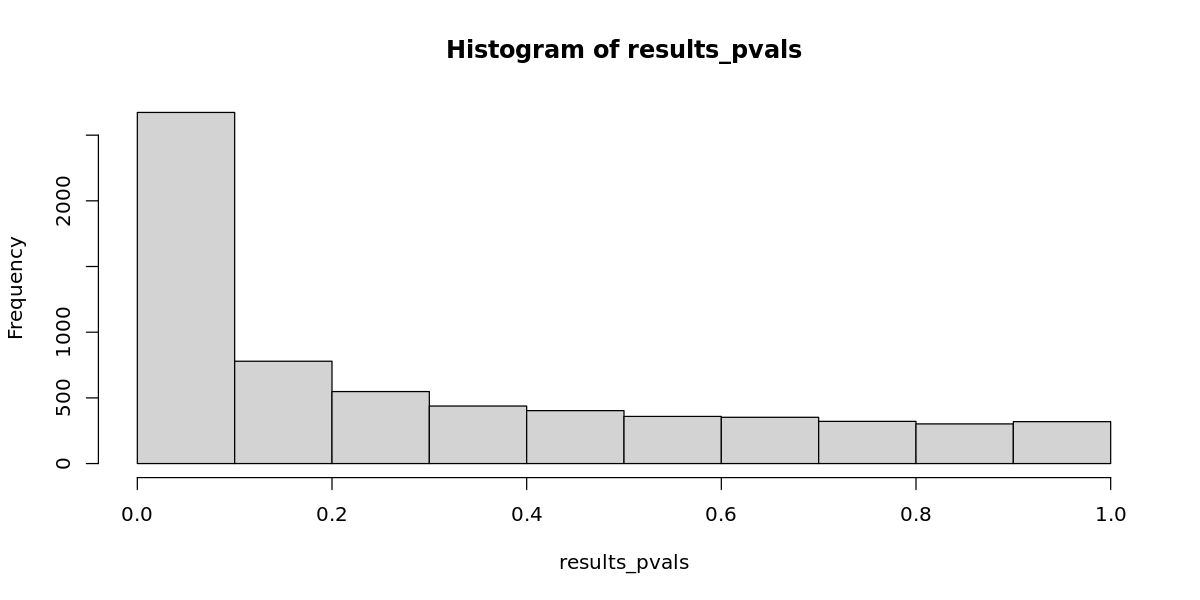

In [38]:
hist (results_pvals)

In [39]:
peaksnps_tests$aov_pval = results_pvals
peaksnps_tests$aov_qval = p.adjust(results_pvals)

In [40]:
peaksnps_tests= peaksnps_tests[order(peaksnps_tests$aov_pval),]

In [41]:
#unisnps = longfs2[!duplicated(longfs2$varID),]

In [42]:
#peaksnps_tests$rsID = unisnps$rsID[match(peaksnps_tests$varID,unisnps$varID)]

In [43]:
sum(is.na(peaksnps_tests$aov_qval))

[1] 1

In [44]:
sum(peaksnps_tests$aov_qval<0.1, na.rm=T)

[1] 129

In [45]:
length(unique(peaksnps_tests$Feature[peaksnps_tests$aov_qval<0.1]))

[1] 123

In [46]:
dim(peaksnps_tests)

[1] 6495   34

- 130 out of 6531 caQTLs pair (peak-snp ) seems significantly cell-type specific/ with different effect sizes
- 124 out of 5935 caQTLs peaks seems significantly cell-type specific/ with different effect sizes

In [179]:
124/5935

[1] 0.02089301

In [47]:
peaksnps_testsuni = peaksnps_tests[!duplicated(peaksnps_tests$Feature),]

In [48]:
longf = subset(longf , cell %in% celltypes)

agg = aggregate(cell~Feature, longf, length)

priv = as.character(unique(agg$Feature[agg$cell==1]))

In [49]:
table(peaksnps_testsuni$Feature %in% priv, peaksnps_testsuni$aov_qval<0.1)

       
        FALSE TRUE
  FALSE  3894   66
  TRUE   1891   56

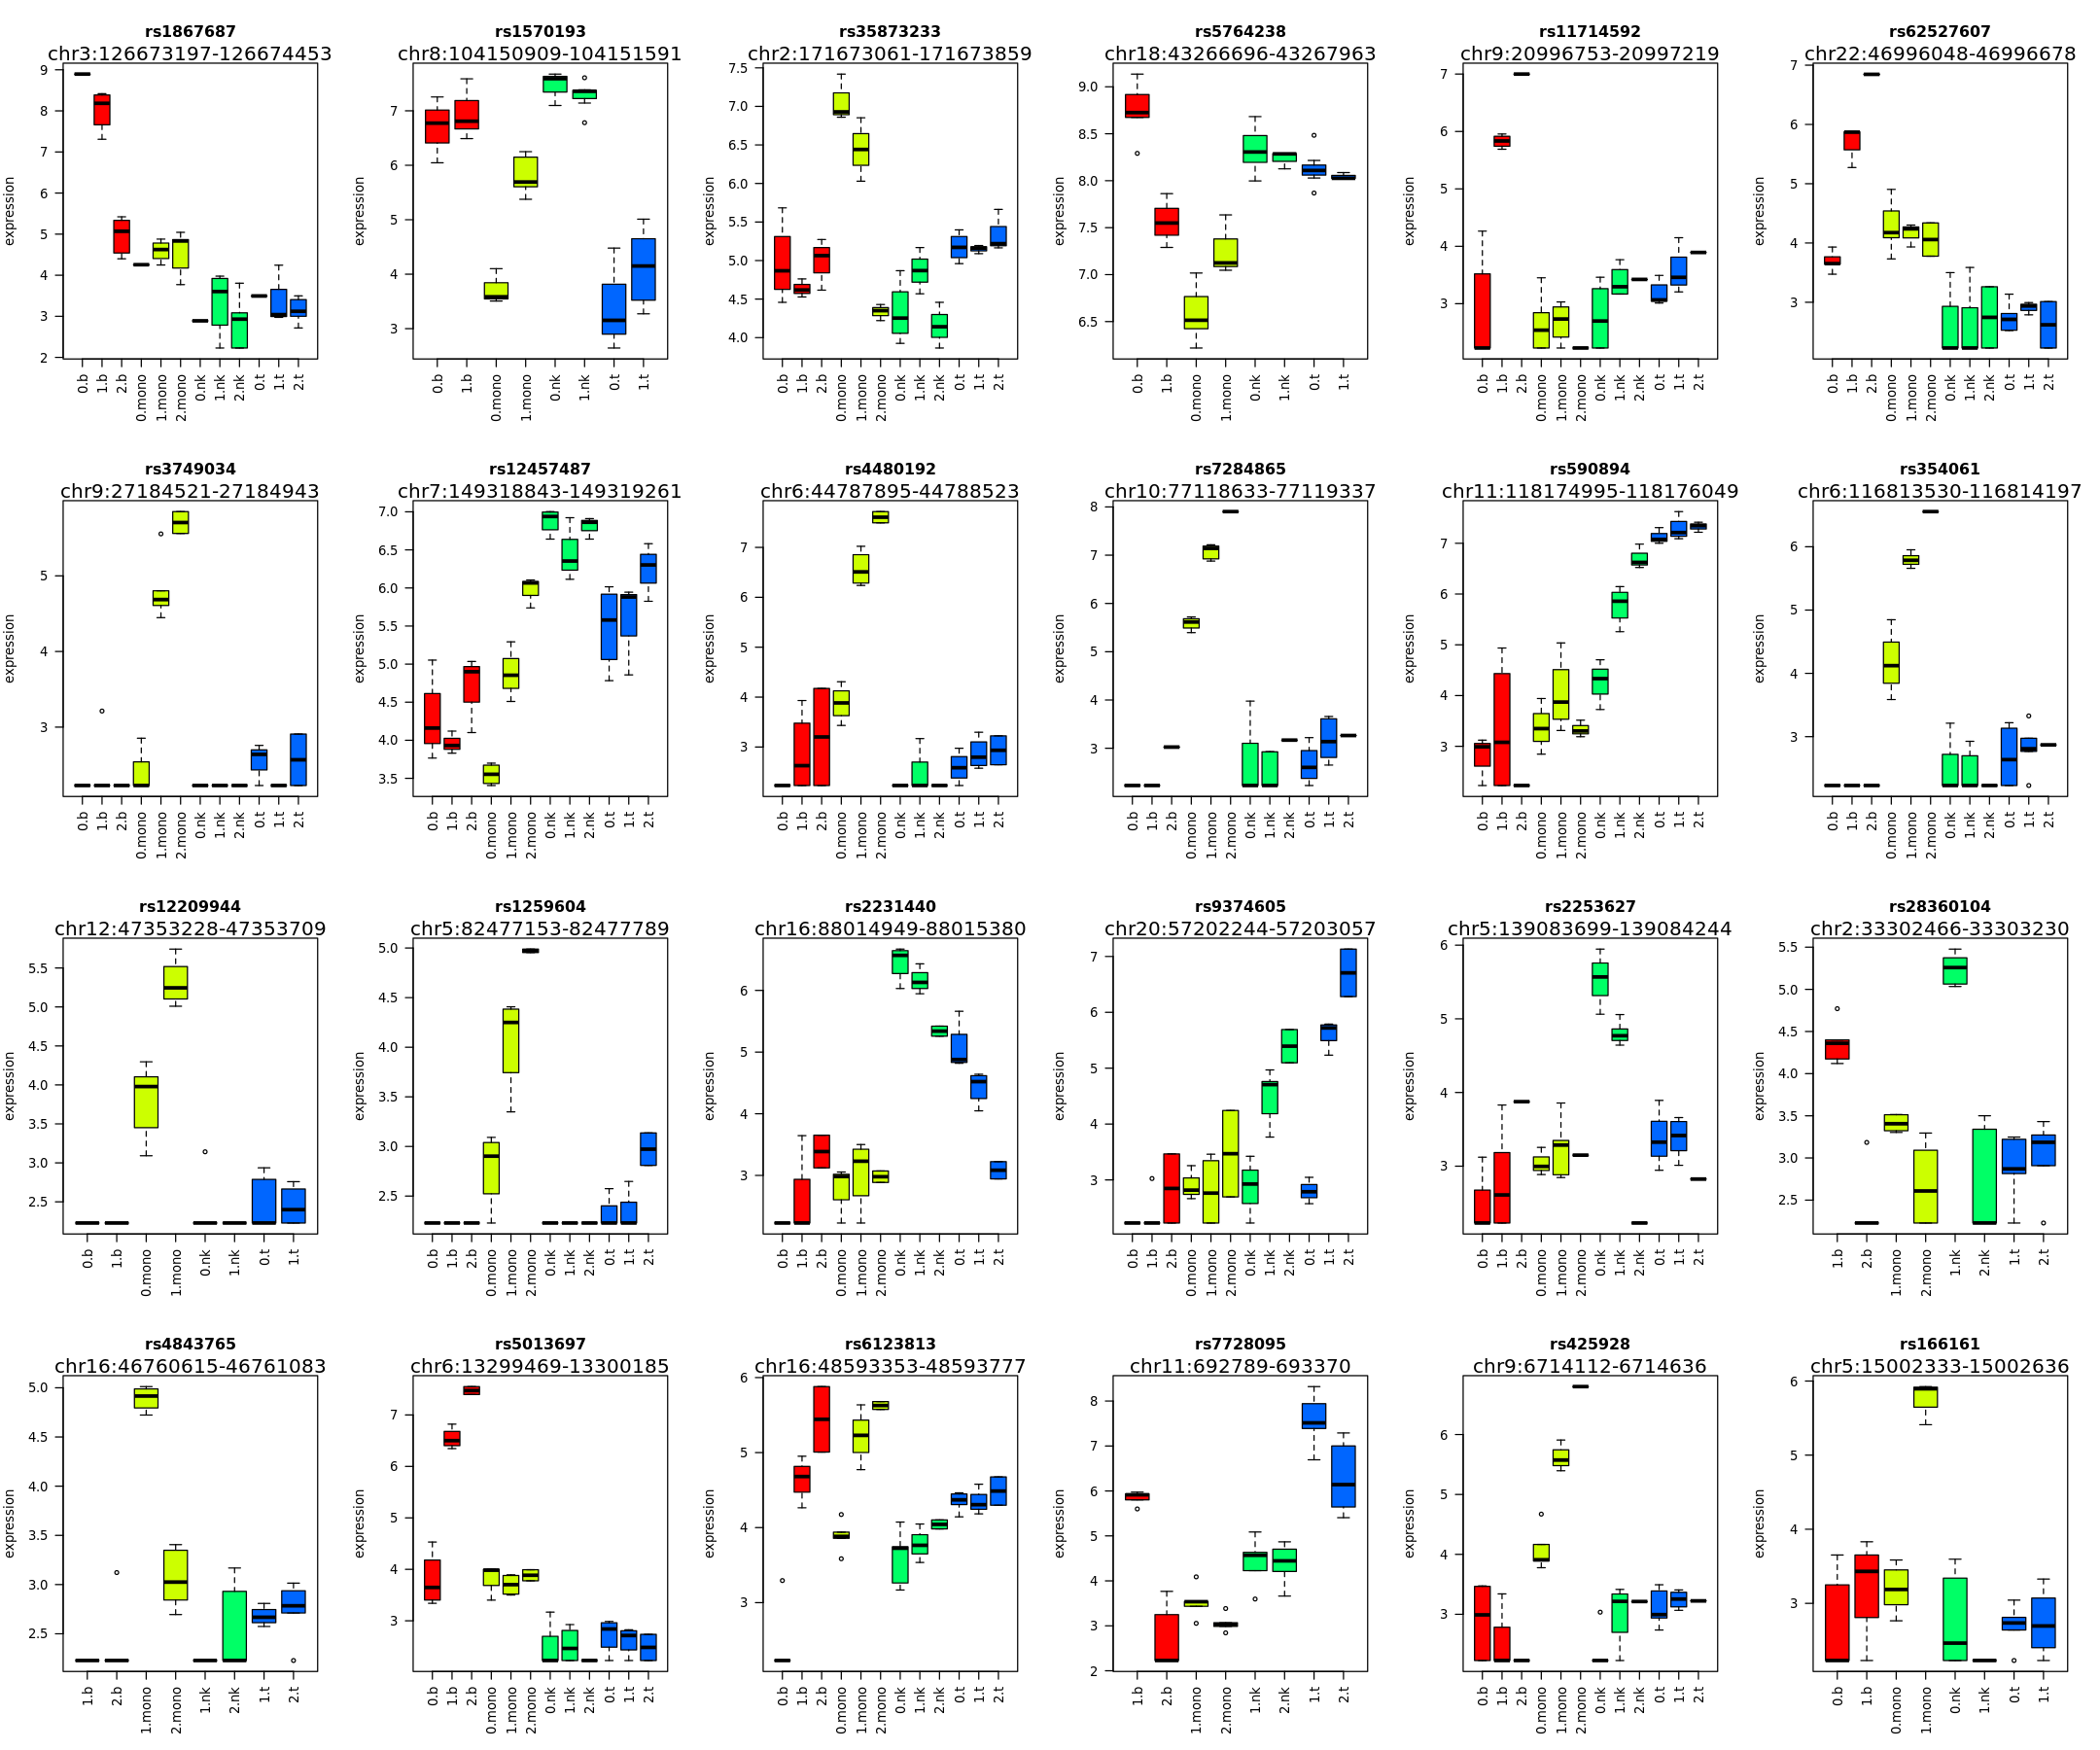

In [50]:
options(repr.plot.width=18, repr.plot.height=15)
par(mfrow=c(4,6))
for(i in 25:48){

    gene_id = as.character(peaksnps_testsuni[i,]$Feature)
    snp_id  = as.character(peaksnps_testsuni[i,]$varID)
   sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),4))      

boxplot(expression~genotype+celltype,sample_data, las=2, 
        col = rep(rainbow(5),each=length(unique(sample_data$genotype))), 
        xlab=NA, main=peaksnps_tests$rsID[i])
mtext(gene_id)
      }

In [65]:
some_examples = c(4,6,16,18,19,29,41)

In [67]:
write.csv(peaksnps_tests[some_examples,], "../example_boxplots/some_new_examples.csv")

In [49]:
peaksnps_tests[peaksnps_tests$Feature=="chr5:54048694-54049421",]

,Feature,varID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,P_VAl,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,rsID,feature_snp,aov_pval,aov_qval
,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<lgl>,<lgl>,<lgl>,<fct>,<lgl>,<fct>,<chr>,<dbl>,<dbl>
225824,chr5:54048694-54049421,chr5:54048853:T:G,chr5,54048853,T,G,0.45,1.551882,0.999945,-2.690267,⋯,0.0006021224,TRUE,TRUE,FALSE,t,FALSE,rs1445837,chr5:54048694-54049421;chr5:54048853:T:G,6.832817e-08,0.0004299892
46129,chr5:54048694-54049421,chr5:54048994:A:G,chr5,54048994,A,G,0.45,1.551882,0.996360,-2.200354,⋯,0.0017951206,TRUE,TRUE,FALSE,mono,FALSE,rs1867687,chr5:54048694-54049421;chr5:54048994:A:G,6.832817e-08,0.0004299892
300,chr5:54048694-54049421,chr5:54039907:G:A,chr5,54039907,G,A,0.35,1.160488,0.996255,-2.109245,⋯,0.0039500879,TRUE,TRUE,FALSE,b,FALSE,rs9292069,chr5:54048694-54049421;chr5:54039907:G:A,7.640115e-05,0.4670402132


In [74]:
examples = c("rs61943586","rs13294415","rs11136478","rs10888395","rs1475159",'rs1867687')

In [72]:
snps_pos =sapply(examples, function(y) which(peaksnps_tests$rsID==y) )

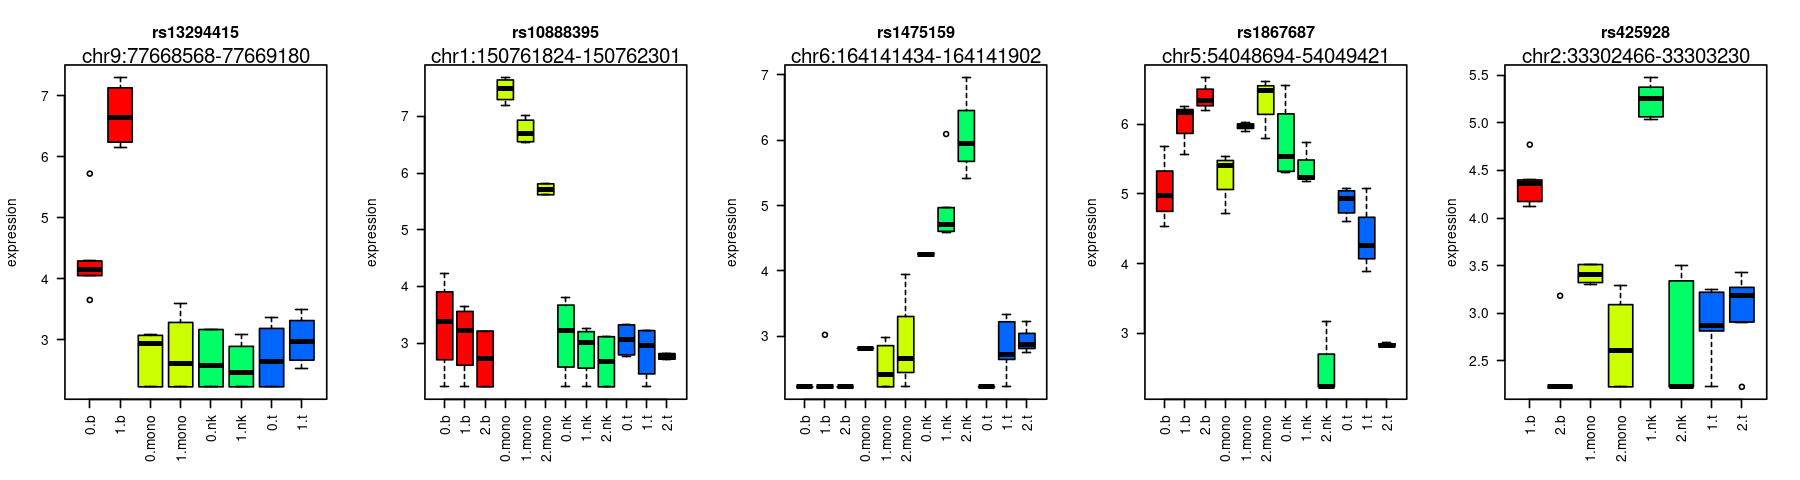

In [73]:
options(repr.plot.width=15, repr.plot.height=4)
par(mfrow=c(1,5))
for(i in na.omit(unlist(snps_pos))){

    gene_id = as.character(peaksnps_tests[i,]$Feature)
    snp_id  = as.character(peaksnps_tests[i,]$varID)
sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),4))      

boxplot(expression~genotype+celltype,sample_data, las=2, 
        col = rep(rainbow(5),each=length(unique(sample_data$genotype))), 
        xlab=NA, main=peaksnps_tests$rsID[i])
mtext(gene_id)
      }

In [55]:
peaksnps_tests[peaksnps_tests$rsID %in% examples,]

,Feature,varID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,P_VAl,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,rsID,feature_snp,aov_pval,aov_qval
,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<lgl>,<lgl>,<lgl>,<fct>,<lgl>,<fct>,<chr>,<dbl>,<dbl>
46129,chr5:54048694-54049421,chr5:54048994:A:G,chr5,54048994,A,G,0.45,1.551882,0.996360,-2.200354,⋯,0.0017951206,TRUE,TRUE,FALSE,mono,FALSE,rs1867687,chr5:54048694-54049421;chr5:54048994:A:G,6.832817e-08,0.0004299892
389,chr9:77668568-77669180,chr9:77669152:G:C,chr9,77669152,G,C,0.20,0.625000,0.999919,-1.921173,⋯,0.0064930558,TRUE,TRUE,FALSE,b,FALSE,rs13294415,chr9:77668568-77669180;chr9:77669152:G:C,1.250551e-03,1.0000000000
45987,chr1:150761824-150762301,chr1:150762171:C:T,chr1,150762171,C,T,0.40,0.277778,0.999946,-2.887407,⋯,0.0012959651,TRUE,TRUE,FALSE,mono,FALSE,rs10888395,chr1:150761824-150762301;chr1:150762171:C:T,8.146761e-03,1.0000000000
173373,chr6:164141434-164141902,chr6:164141649:T:C,chr6,164141649,T,C,0.60,0.625000,0.996848,-2.650218,⋯,0.0004475191,TRUE,TRUE,FALSE,nk,FALSE,rs1475159,chr6:164141434-164141902;chr6:164141649:T:C,1.554775e-01,1.0000000000


In [56]:
peaksnps_tests$private = peaksnps_tests$Feature %in% priv

In [59]:
priv_sel = peaksnps_tests[peaksnps_tests$private,]

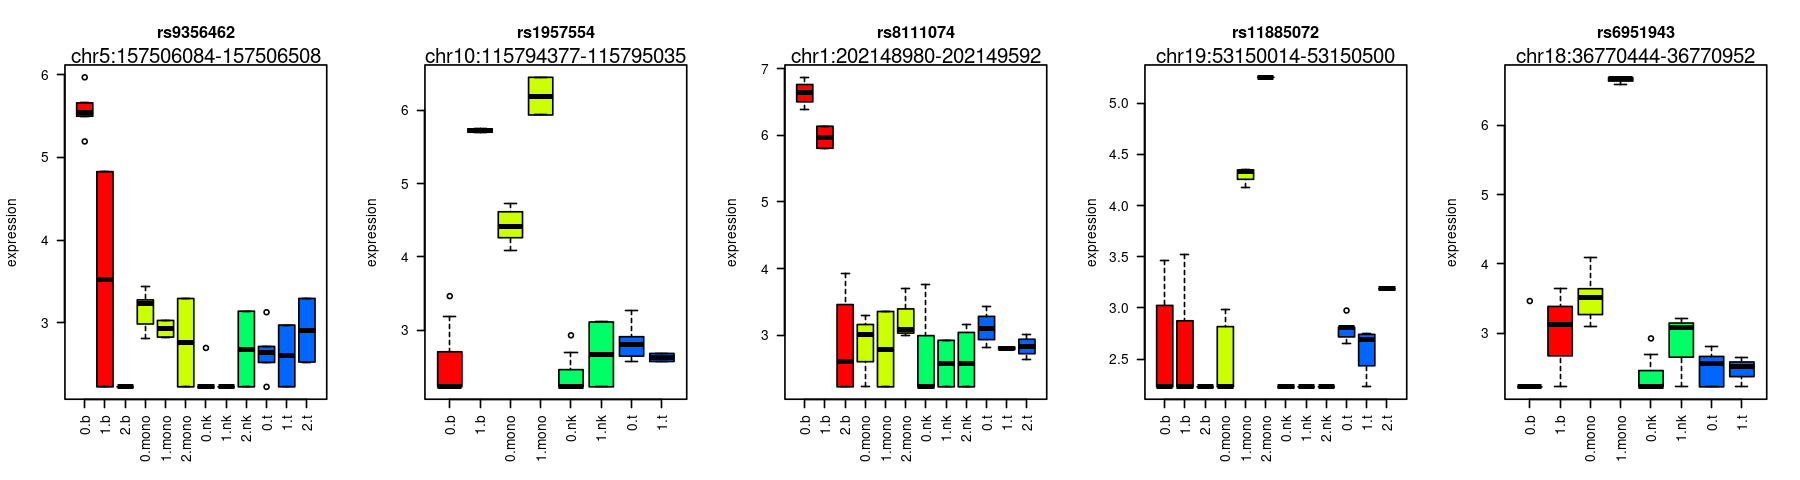

In [60]:
options(repr.plot.width=15, repr.plot.height=4)
par(mfrow=c(1,5))
for(i in 1:5){

    gene_id = as.character(priv_sel[i,]$Feature)
    snp_id  = as.character(priv_sel[i,]$varID)
sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),4))      

boxplot(expression~genotype+celltype,sample_data, las=2, 
        col = rep(rainbow(5),each=length(unique(sample_data$genotype))), 
        xlab=NA, main=peaksnps_tests$rsID[i])
mtext(gene_id)
      }

In [75]:
priv_nk = subset(priv_sel, cell=="nk")

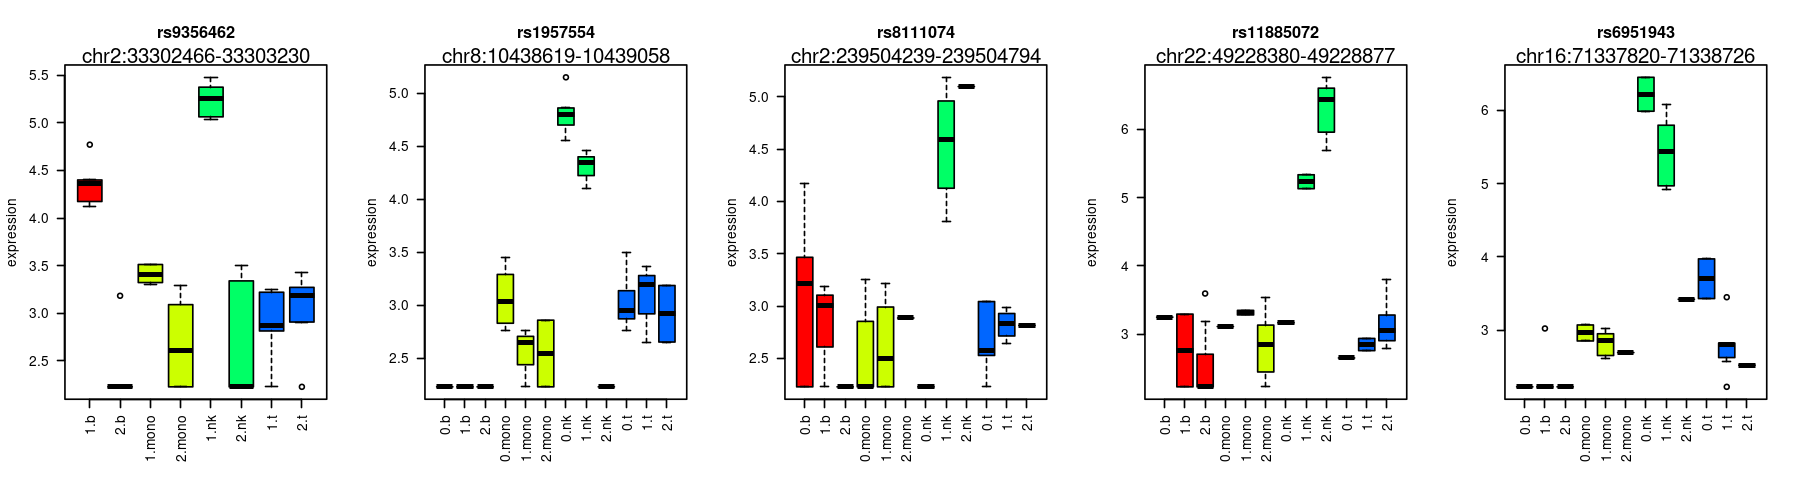

In [77]:
options(repr.plot.width=15, repr.plot.height=4)
par(mfrow=c(1,5))
for(i in 1:5){

    gene_id = as.character(priv_nk[i,]$Feature)
    snp_id  = as.character(priv_nk[i,]$varID)
sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),4))      

boxplot(expression~genotype+celltype,sample_data, las=2, 
        col = rep(rainbow(5),each=length(unique(sample_data$genotype))), 
        xlab=NA, main=peaksnps_tests$rsID[i])
mtext(gene_id)
      }

In [82]:
priv_nk = subset(priv_sel, cell=="t")

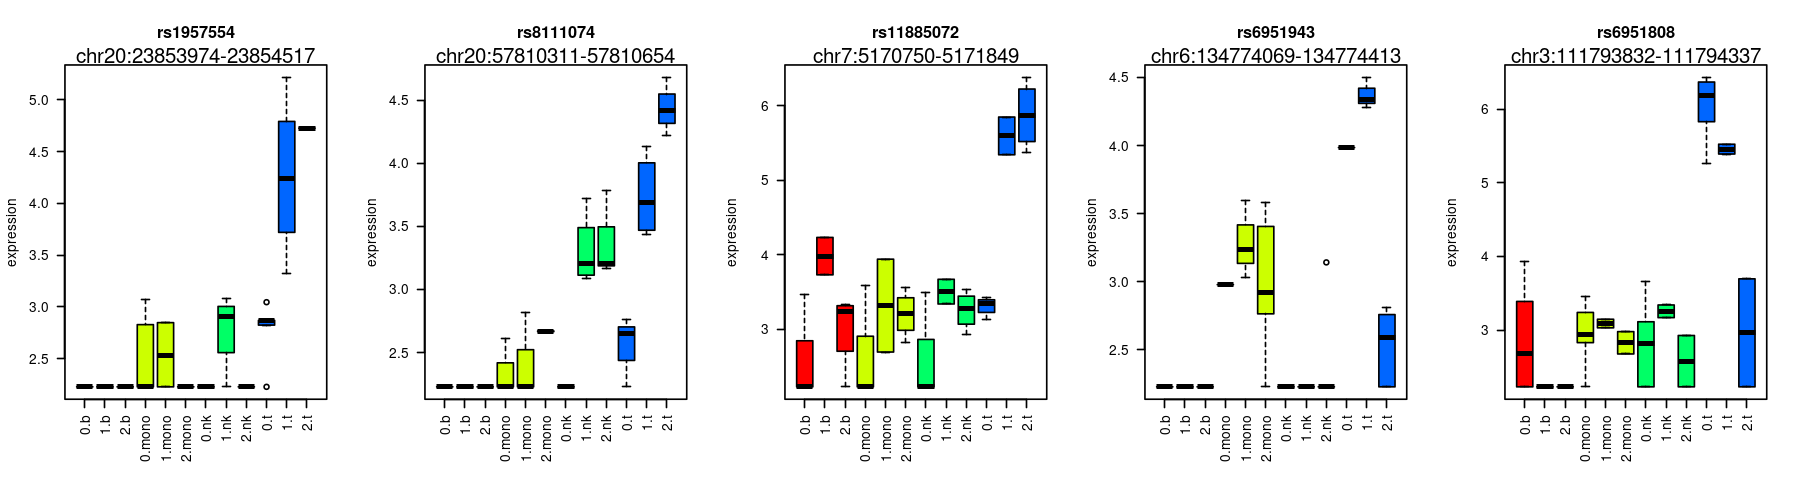

In [85]:
options(repr.plot.width=15, repr.plot.height=4)
par(mfrow=c(1,5))
for(i in 2:6){

    gene_id = as.character(priv_nk[i,]$Feature)
    snp_id  = as.character(priv_nk[i,]$varID)
sample_data    = data.frame(info, expression = caQTL_counts[gene_id,], 
                            genotype = rep(unlist(genotypes[snp_id,]),4))      

boxplot(expression~genotype+celltype,sample_data, las=2, 
        col = rep(rainbow(5),each=length(unique(sample_data$genotype))), 
        xlab=NA, main=peaksnps_tests$rsID[i])
mtext(gene_id)
      }

In [51]:
longfs = subset(longf, flag_fdr10==T & exclude==F)

agg2 = aggregate(cell~Feature, longfs, length)

privs = as.character(unique(agg2$Feature[agg2$cell==1]))

peaksnps_tests$exclusive = peaksnps_tests$Feature %in% privs

In [52]:
peaksnps_tests = merge(peaksnps_tests, agg, by="Feature")

colnames(peaksnps_tests)[ncol(peaksnps_tests)] = "n_tested_cells"

peaksnps_tests = merge(peaksnps_tests, agg2, by="Feature")

colnames(peaksnps_tests)[ncol(peaksnps_tests)] = "n_significant_cells"

In [53]:
table(peaksnps_tests$n_significant_cells, peaksnps_tests$n_tested_cells)

   
       1    2    3    4
  1 1947 1048  833 1182
  2    0  170  277  496
  3    0    0   84  316
  4    0    0    0  142

In [54]:
write.csv(peaksnps_tests, "results_anova_broad.csv")